[*********************100%***********************]  1 of 1 completed
<ipython-input-3-3e9b8696e884>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['price_scaled'] = scaler.fit_transform(df[['price']])
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/optimizers/base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


Epoch 1/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 11s 120ms/step - loss: 0.0634
Epoch 2/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 9s 102ms/step - loss: 0.0034
Epoch 3/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 10s 94ms/step - loss: 0.0028
Epoch 4/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 6s 119ms/step - loss: 0.0023
Epoch 5/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 5s 93ms/step - loss: 0.0023
Epoch 6/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 7s 133ms/step - loss: 0.0022
Epoch 7/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 8s 93ms/step - loss: 0.0020
Epoch 8/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 7s 121ms/step - loss: 0.0022
Epoch 9/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 9s 90ms/step - loss: 0.0023
Epoch 10/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 7s 119ms/step - loss: 0.0018
Epoch 11/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 9s 100ms/step - loss: 0.0017
Epoch 12/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 10s 93ms/step - loss: 0.0020
Epoch 13/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 7s 123ms/step - loss: 0.0016
Epoch 14/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 9s 94ms/step - loss: 0.0013
Epoch 15/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 6s 123

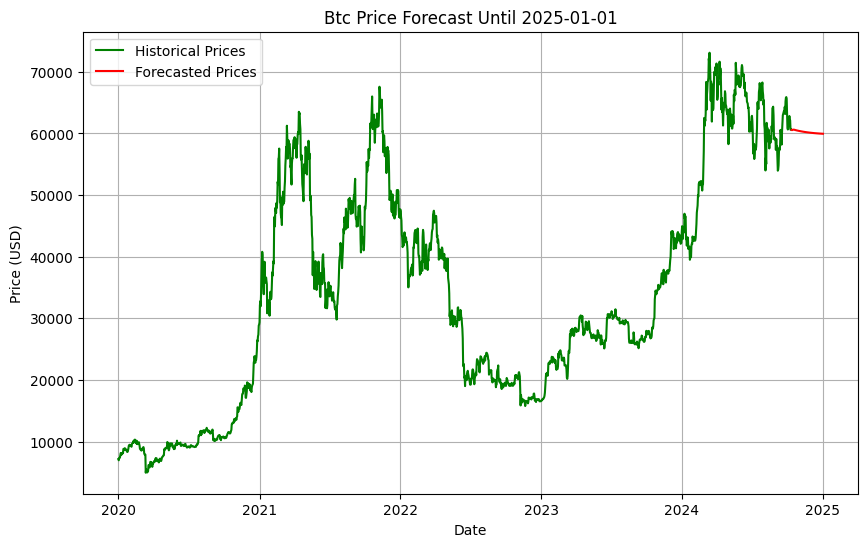


Forecasted Prices until 2025-01-01:

    timestamp         price
0  2024-10-12  60552.812500
1  2024-10-13  60533.300781
2  2024-10-14  60559.738281
3  2024-10-15  60588.402344
4  2024-10-16  60605.519531
..        ...           ...
77 2024-12-28  59956.683594
78 2024-12-29  59952.714844
79 2024-12-30  59948.824219
80 2024-12-31  59945.007812
81 2025-01-01  59941.273438

[82 rows x 2 columns]


In [3]:
import requests
import pandas as pd
import numpy as np
import yfinance as yf
from datetime import datetime, timedelta
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt

# 1. Fetching historical data
def fetch_crypto_data(symbol, start_date):
    ticker_symbol = f"{symbol}-USD"
    df = yf.download(ticker_symbol, start=start_date)
    if df.empty:
        print("Error: No data fetched. Check the cryptocurrency symbol and date range.")
        return None
    df.reset_index(inplace=True)
    df.rename(columns={'Date': 'timestamp', 'Close': 'price'}, inplace=True)
    df = df[['timestamp', 'price']]
    return df

# 2. Data Preprocessing
def preprocess_data(df):
    scaler = MinMaxScaler()
    df['price_scaled'] = scaler.fit_transform(df[['price']])
    return df, scaler

# 3. Preparing data for LSTM
def prepare_lstm_data(df, time_steps=60):
    X, y = [], []
    for i in range(time_steps, len(df)):
        X.append(df['price_scaled'].values[i-time_steps:i])
        y.append(df['price_scaled'].values[i])
    X, y = np.array(X), np.array(y)
    X = np.reshape(X, (X.shape[0], X.shape[1], 1))
    return X, y

# 4. Defining the LSTM model with adjusted parameters
def create_lstm_model(input_shape):
    model = Sequential()
    model.add(LSTM(100, return_sequences=True, input_shape=input_shape))
    model.add(Dropout(0.2))
    model.add(GRU(100, return_sequences=False))  # GRU layer
    model.add(Dropout(0.2))
    model.add(Dense(25, activation='relu'))
    model.add(Dense(1))
    optimizer = Adam(learning_rate=0.001, decay=1e-6)  # Learning rate decay
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model

# 5. Train the model with Early Stopping
def train_model(model, X_train, y_train, epochs=100, batch_size=32):  #epochs=100
    early_stop = EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)
    model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=1, callbacks=[early_stop])
    return model

# 6. Multi-day prediction with historical input
def forecast_multiple_days(model, last_60_days, scaler, num_days):
    predictions = []
    input_data = last_60_days

    for _ in range(num_days):
        pred_scaled = model.predict(input_data)
        pred_price = scaler.inverse_transform(pred_scaled)[0][0]
        predictions.append(pred_price)

        # Updating input data using actual last prediction each step for realistic forecasting
        new_input = np.append(input_data[:, 1:, :], [[pred_scaled[0]]], axis=1)
        input_data = new_input

    return predictions

# User input
crypto_name = input("Enter Cryptocurrency Symbol (e.g., BTC): ")
start_date = "2020-01-01"
target_date = input("Enter Target Date for Prediction (YYYY-MM-DD): ")

# Fetching, preprocessing and preparing data
df = fetch_crypto_data(crypto_name, start_date)
df, scaler = preprocess_data(df)
X, y = prepare_lstm_data(df)
input_shape = (X.shape[1], X.shape[2])

# Creating and training model
model = create_lstm_model(input_shape)
model = train_model(model, X, y, epochs=100)  # epochs=100

# Days to forecast
last_date = df['timestamp'].iloc[-1]
target_date_obj = datetime.strptime(target_date, '%Y-%m-%d')
num_days = (target_date_obj - last_date).days

# Make forecast
last_60_days = df['price_scaled'][-60:].values.reshape(1, 60, 1)
forecasted_prices = forecast_multiple_days(model, last_60_days, scaler, num_days)

# Appending forecasted prices
forecast_dates = [last_date + timedelta(days=i) for i in range(1, num_days + 1)]
forecast_df = pd.DataFrame({'timestamp': forecast_dates, 'price': forecasted_prices})

# Combining with historical data
combined_df = pd.concat([df[['timestamp', 'price']], forecast_df], ignore_index=True)

# Calculating RMSE and MAE
predictions_train = model.predict(X)
predictions_train = scaler.inverse_transform(predictions_train)
y_train_actual = scaler.inverse_transform(y.reshape(-1, 1))
rmse = np.sqrt(mean_squared_error(y_train_actual, predictions_train))
mae = mean_absolute_error(y_train_actual, predictions_train)

print(f"RMSE on Training Data: {rmse}")
print(f"MAE on Training Data: {mae}")

# Plot
plt.figure(figsize=(10, 6))
plt.plot(df['timestamp'], df['price'], color='green', label='Historical Prices')
plt.plot(forecast_df['timestamp'], forecast_df['price'], color='red', label='Forecasted Prices', linestyle='-')
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.title(f"{crypto_name.capitalize()} Price Forecast Until {target_date}")
plt.legend()
plt.grid()
plt.show()

# Forecasted Prices
print(f"\nForecasted Prices until {target_date}:\n")
print(forecast_df)
